# Exploring the dataset


In [3]:
import os
import sys

import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb
import tensorflow as tf
import lightgbm as lgb

from interpret.glassbox import ExplainableBoostingRegressor
from mapie.regression import MapieQuantileRegressor
from quantile_forest import RandomForestQuantileRegressor

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..")))

from src.utils.model import (
    split_dataset,
    compare_models_per_station,
    create_deep_model,
    XGBQuantileRegressor,
    standardize_prediction_intervals,
    standardize_values,
    get_station_stats,
)

In [12]:
INPUT_DIR = "../../../../data/input/"
DATASET_DIR = "../../../../dataset/"

DATASET_TRANSFORMS = [
    "rm_gnv_st",
    "pca",
    "snow_index",
    # "oh_enc_date",
    "cyc_enc_date",
    "clust_index",
    "clust_index_oh",
    "clust_hydro",
    "clust_hydro_oh",
    # "scl_feat",
    # "scl_feat_wl",  # Scale all except waterflow lag
    "rm_wl",  # remove custom generated water_flow_lag 3w & 4w ---> Need USE_CUSTOM_PREPROCESS = True
    "slct_ma",  # keep only specific mobile average 2w or/and 3w or/and 4w ---> Need USE_CUSTOM_PREPROCESS = True
    "lag_slope",  # add an indicator that is calculated between water_flow_lag 1w and 2w
]

PCA_THRESHOLD = 0.98
N_CLUSTER = 5

DATASET_SPEC = "_".join(DATASET_TRANSFORMS)

if "pca" in DATASET_TRANSFORMS:
    DATASET_SPEC += f"_pct_{PCA_THRESHOLD}"

if "clust_index" in DATASET_TRANSFORMS:
    DATASET_SPEC += f"_geocl_{N_CLUSTER}"

if "clust_hydro" in DATASET_TRANSFORMS:
    DATASET_SPEC += f"_hydcl_{N_CLUSTER}"

MODEL_DIR = f"../../../../models/{DATASET_SPEC}/"

SEED = 42
NUMBER_OF_WEEK = 4  # Number of weeks to predict one model is trained per week

WATER_FLOW_COLUMNS = [
    "water_flow_week1",
    "water_flow_week2",
    "water_flow_week3",
    "water_flow_week4",
]

ALPHA = 0.1
TIME_VALIDATION = "2000-01-01 00:00:00"

In [7]:
dataset_train = pd.read_csv(f"{INPUT_DIR}dataset_{DATASET_SPEC}.csv")

dataset_train = dataset_train.set_index("ObsDate")

if not os.path.exists(f"{MODEL_DIR}final/"):
    os.makedirs(f"{MODEL_DIR}final/")

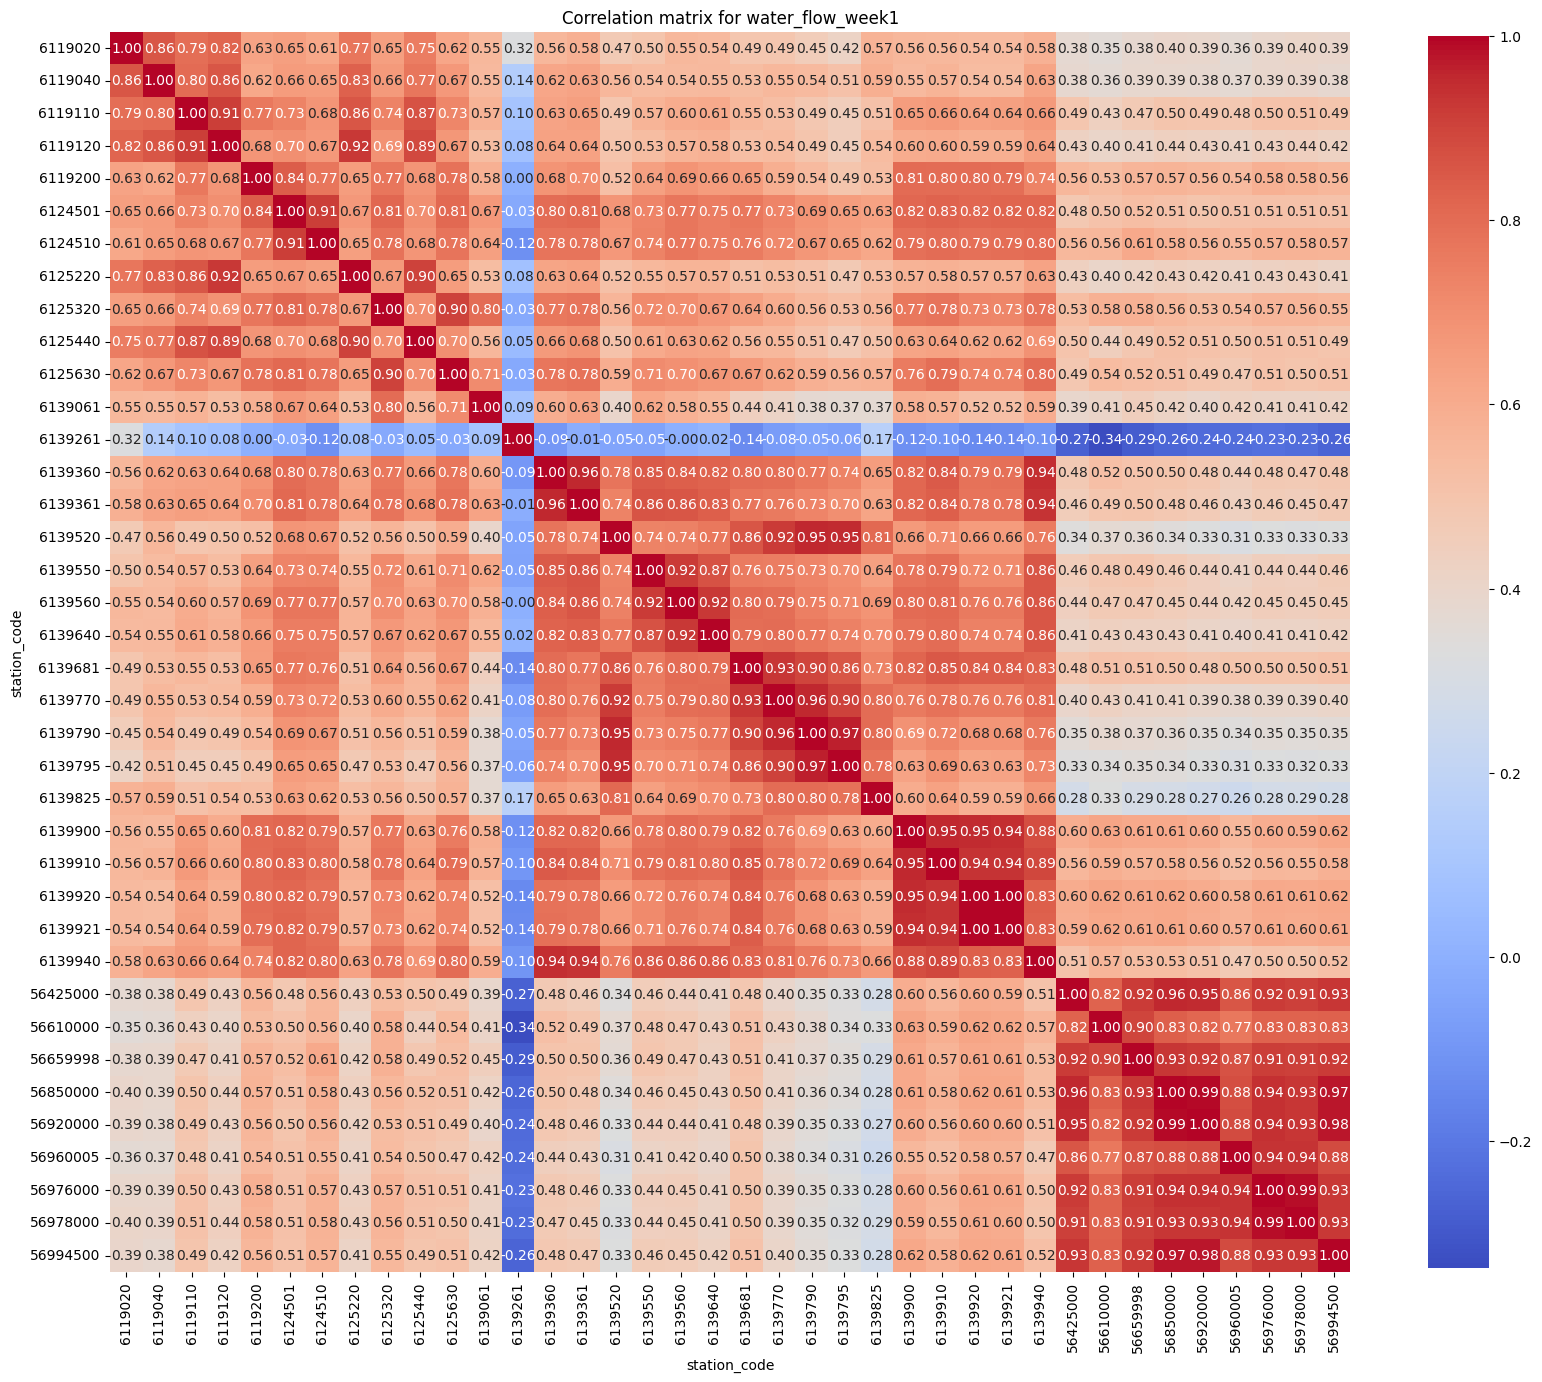

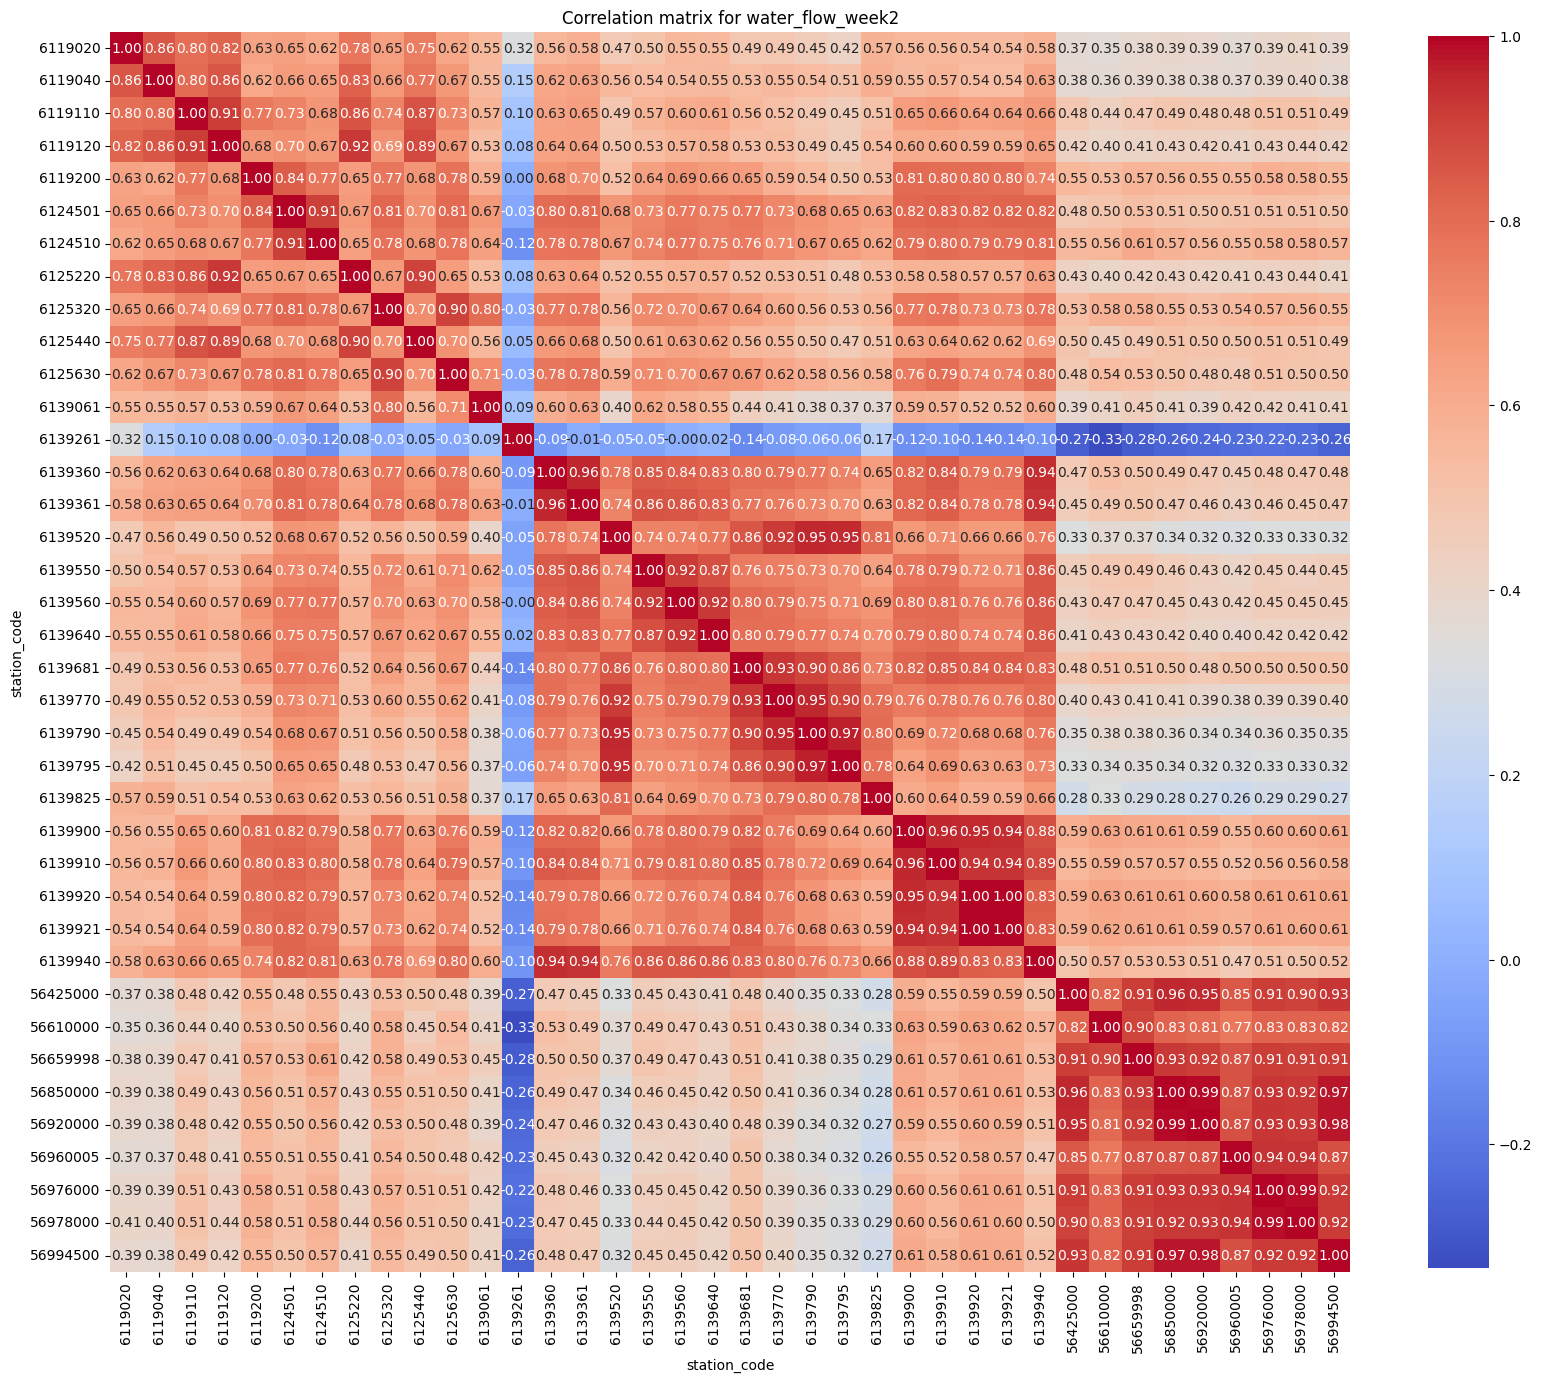

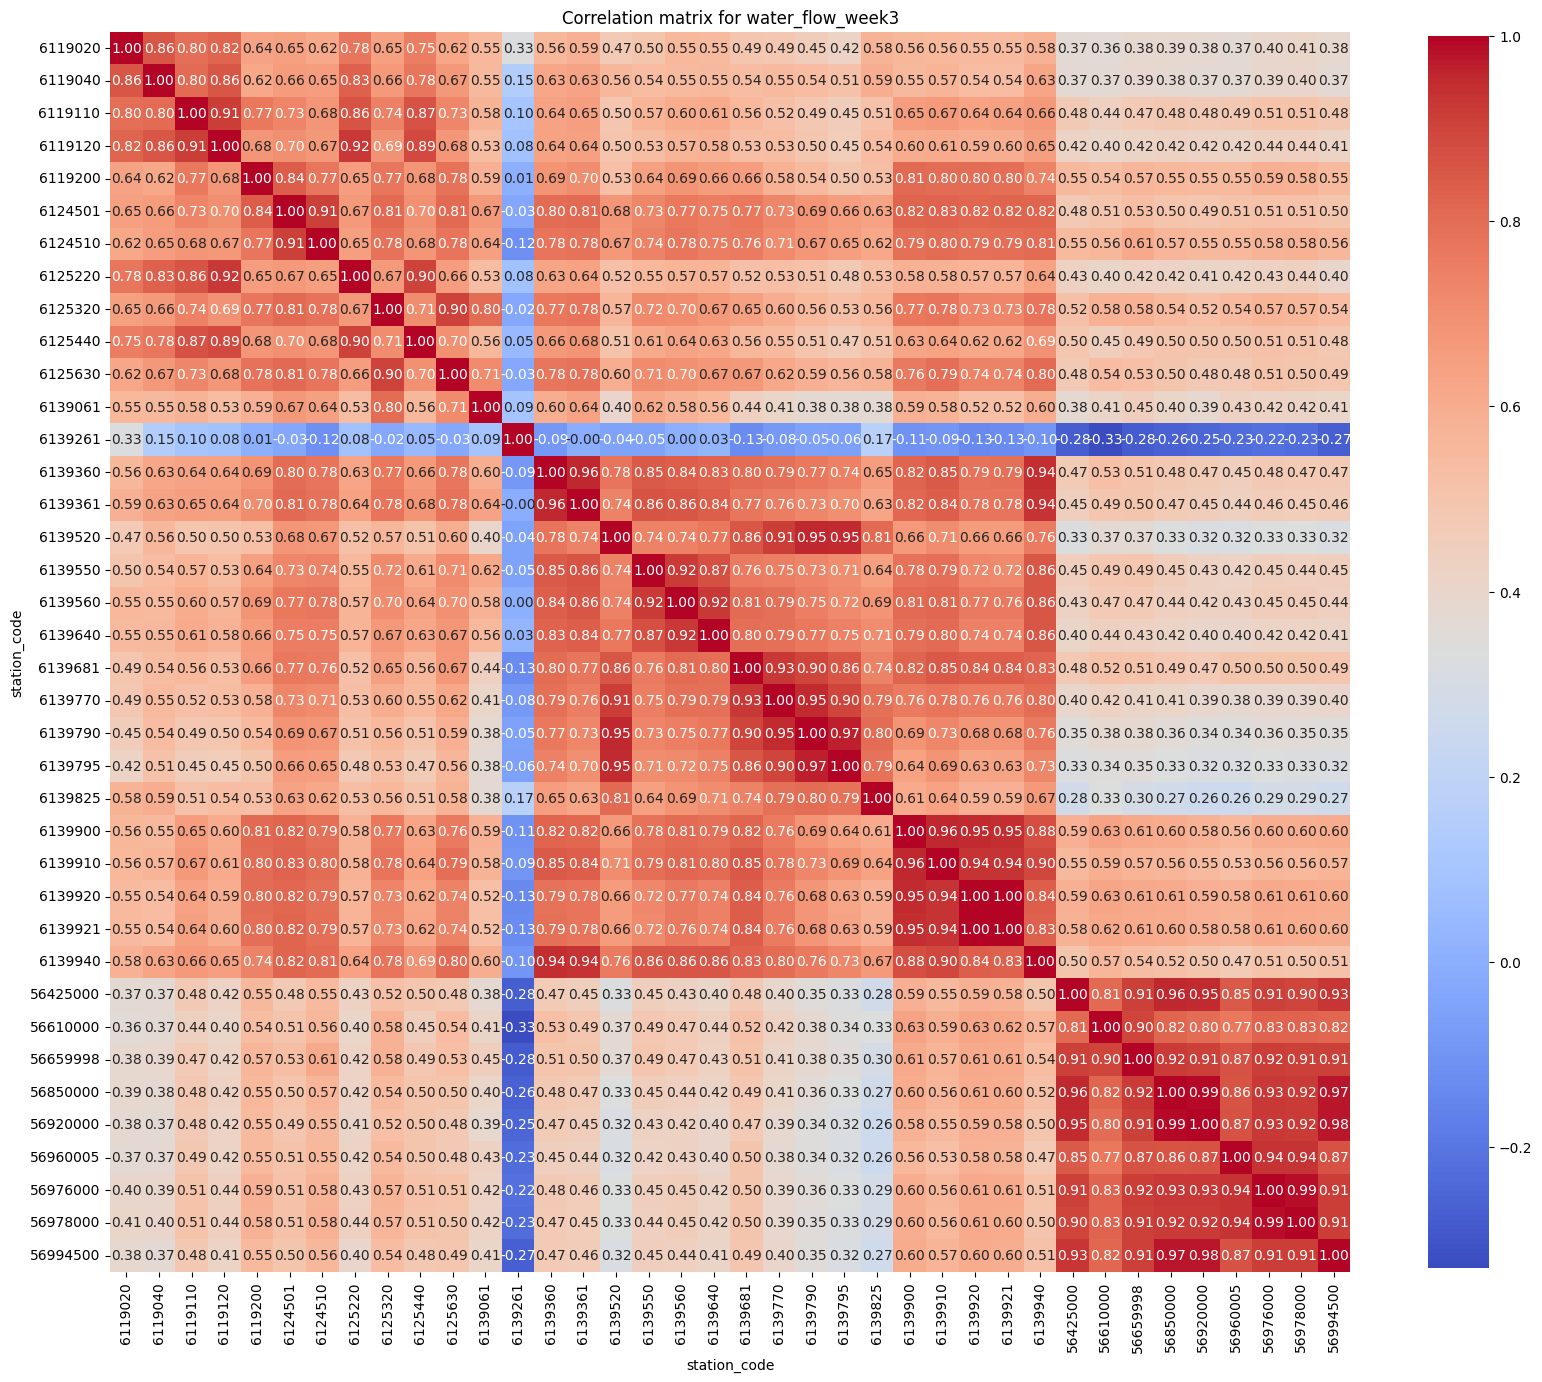

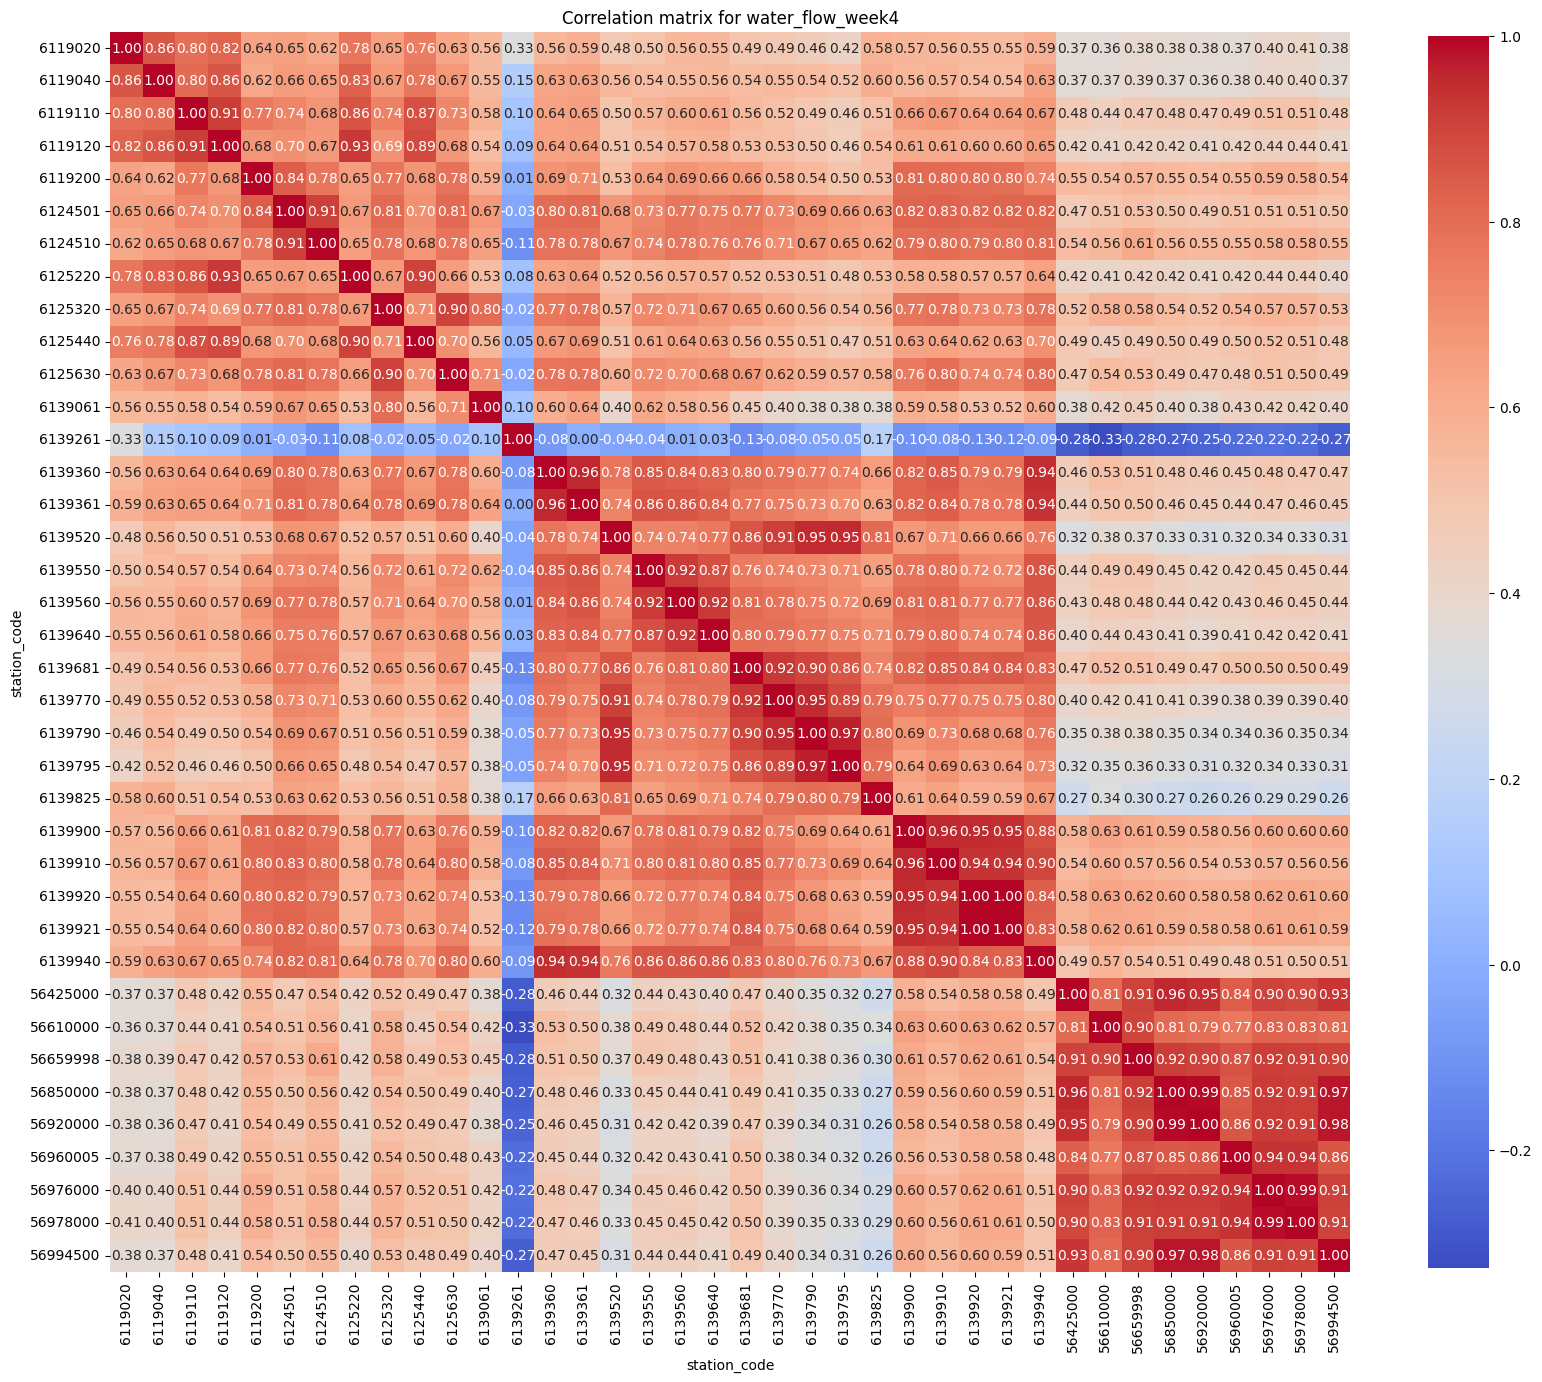

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

for water_flow_column in WATER_FLOW_COLUMNS:
    pivot_dataset = dataset_train.pivot(
        columns="station_code", values=water_flow_column
    )
    correlation_matrix = pivot_dataset.corr(method="spearman")

    plt.figure(figsize=(20, 20))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        square=True,
        cbar_kws={"shrink": 0.8},
    )
    plt.title(f"Correlation matrix for {water_flow_column}")
    plt.show()

In [ ]:
from statsmodels.tsa.ar_model import AutoReg


def find_best_lag_via_aic(series, max_lag=12):
    best_aic = float("inf")
    best_lag = None

    for lag in range(1, max_lag + 1):
        try:
            model = AutoReg(series.dropna(), lags=lag, old_names=False)
            result = model.fit()
            if result.aic < best_aic:
                best_aic = result.aic
                best_lag = lag
        except:
            continue

    return best_lag

In [44]:
dataset_train.columns

Index(['precipitations_lag_1w_pca_1', 'precipitations_lag_1w_pca_2',
       'precipitations_pca_1', 'precipitations_pca_2',
       'tempartures_lag_1w_pca_1', 'tempartures_pca_1', 'soil_moisture_pca_1',
       'soil_moisture_pca_2', 'soil_moisture_pca_3',
       'evaporation_lag_1w_pca_1', 'evaporation_pca_1',
       'soil_composition_pca_1', 'soil_composition_pca_2',
       'soil_composition_pca_3', 'soil_composition_pca_4',
       'soil_composition_pca_5', 'soil_composition_pca_6',
       'soil_composition_pca_7', 'station_code', 'water_flow_week1',
       'latitude', 'longitude', 'catchment', 'altitude', 'water_flow_lag_1w',
       'water_flow_lag_2w', 'water_flow_ma_4w_lag_1w_gauss',
       'water_flow_week2', 'water_flow_week3', 'water_flow_week4',
       'north_hemisphere', 'snow_index', 'month_sin', 'month_cos',
       'season_sin', 'season_cos', 'region_cluster_1', 'region_cluster_2',
       'region_cluster_3', 'region_cluster_4', 'hydro_cluster_1',
       'hydro_cluster_2', 'h

In [53]:
best_lags = {}

for station, group in dataset_train.groupby("station_code"):
    best_lags[station] = {}
    best_lags[station]["cluster"] = group["north_hemisphere"].iloc[0]
    for col in ["water_flow_lag_1w", "snow_index"]:
        best_lag = find_best_lag_via_aic(group[col], max_lag=30)
        best_lags[station][col] = best_lag

/Users/az-r-ow/Developer/WaterScarcity.Hackathon/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [54]:
best_lags

{6119020: {'cluster': np.int64(1), 'water_flow_lag_1w': 30, 'snow_index': 1},
 6119040: {'cluster': np.int64(1), 'water_flow_lag_1w': 30, 'snow_index': 1},
 6119110: {'cluster': np.int64(1), 'water_flow_lag_1w': 30, 'snow_index': 1},
 6119120: {'cluster': np.int64(1), 'water_flow_lag_1w': 30, 'snow_index': 1},
 6119200: {'cluster': np.int64(1), 'water_flow_lag_1w': 30, 'snow_index': 1},
 6124501: {'cluster': np.int64(1), 'water_flow_lag_1w': 30, 'snow_index': 1},
 6124510: {'cluster': np.int64(1), 'water_flow_lag_1w': 27, 'snow_index': 1},
 6125220: {'cluster': np.int64(1), 'water_flow_lag_1w': 30, 'snow_index': 1},
 6125320: {'cluster': np.int64(1), 'water_flow_lag_1w': 30, 'snow_index': 1},
 6125440: {'cluster': np.int64(1), 'water_flow_lag_1w': 30, 'snow_index': 1},
 6125630: {'cluster': np.int64(1), 'water_flow_lag_1w': 30, 'snow_index': 1},
 6139061: {'cluster': np.int64(1), 'water_flow_lag_1w': 30, 'snow_index': 2},
 6139261: {'cluster': np.int64(1), 'water_flow_lag_1w': 30, 'sno